In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
DATASET_PATH = 'mnist_data'

In [3]:
class NoiseTransform(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        if random.random() <= self.p:
            noise_factor = 0.4
            noisy_image = image + noise_factor * np.random.normal(
                loc=0.0, scale=1.0, size=image.shape
            )

            return np.clip(noisy_image, 0.0, 1.0).astype(np.float32)
        else:
            return image

In [4]:
transform = transforms.Compose([NoiseTransform(p=0.75),transforms.ToTensor()])

In [5]:
def visualize_images(data, n_rows, n_cols):
    n_samples = n_rows * n_cols

    if len(data) != n_samples:
        sample_indices = np.random.choice(len(data), n_samples, replace=len(data) < n_samples)
    else:
        sample_indices = np.arange(len(data)).astype(int)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(data[sample_index][0], cmap='gray')
        plt.axis("off")
    plt.show()

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=transforms.ToTensor(), label_transform=transforms.ToTensor()):
        # list of tuples: (img_path, label)
        self._data = MNIST(DATASET_PATH, train=train, download=True)
        # for augmentation
        self._transform = transform
        self._label_transform = label_transform

    def __len__(self):
        return len(self._data)

    def __getitem__(self, index):
        img, label = self._data[index]

        img_noisy = self._transform(img)
        img = self._label_transform(img)

        return img_noisy, img

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 3, padding=(1,1))
        self.enc_pool1 = nn.MaxPool2d(2, 2)
        self.enc_conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.enc_pool2 = nn.MaxPool2d(2, 2)
        # Decoder
        self.dec_tconv1 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1)
        self.dec_tconv2 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1)
        self.dec_conv1 = nn.Conv2d(32, 1, 3, padding=(1,1))
    def forward(self, x):
        # Encoder
        x = self.enc_pool1(F.relu(self.enc_conv1(x)))
        x = self.enc_pool2(F.relu(self.enc_conv2(x)))
        
        # Decoder
        x = F.relu(self.dec_tconv1(x))
        x = F.relu(self.dec_tconv2(x))
        print(x[0])
        
        x = torch.sigmoid(self.dec_conv1(x))
        return x

In [8]:
class AutoEncoderModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.autoencoder = AutoEncoder()

        self.loss = nn.BCELoss()

    def forward(self, x):
        x = self.autoencoder(x)
        return x

    def training_step(self, batch, batch_idx):
        noisy_img, img = batch

        denoised_img = self(noisy_img)
        loss = self.loss(denoised_img, img)

        return {'loss': loss}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=5e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  mode='min',
                                                                  factor=0.2,
                                                                  patience=5,
                                                                  verbose=True)
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_loss"
        }

        return [optimizer], [lr_dict]

    def validation_step(self, batch, batch_idx):
        noisy_img, img = batch

        denoised_img = self(noisy_img)
        loss = self.loss(denoised_img, img)

        return {'val_loss': loss}

    def training_epoch_end(self, outputs):
        """log and display average train loss across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()

        print(f"| Train_loss: {avg_loss:.5f}")

        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)

    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()

        print(f"[Epoch {self.trainer.current_epoch:3}] Val_loss: {avg_loss:.5f}", end=" ")

        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)

In [9]:
train_dataset = MNISTDataset(train=True, transform=transform)
val_dataset = MNISTDataset(train=False, transform=transform)

In [10]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

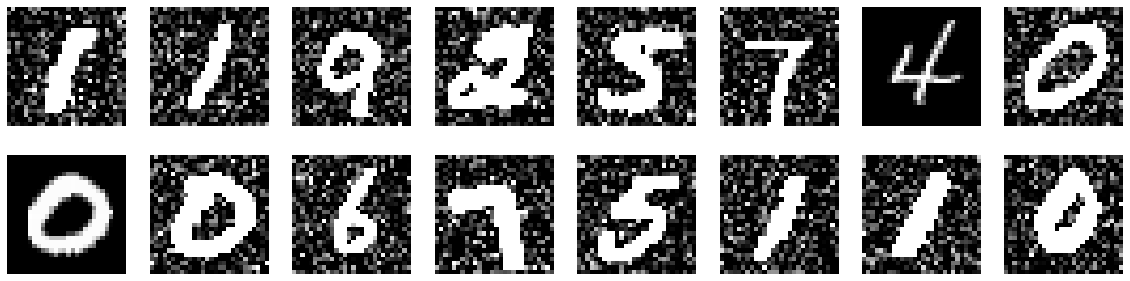

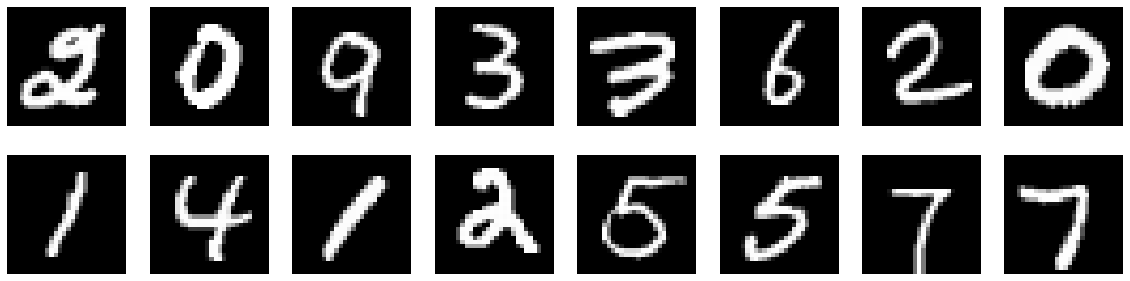

In [11]:
sample_batch = next(iter(train_dl))
visualize_images(sample_batch[0], 2, 8)
visualize_images(sample_batch[1], 2, 8)

In [12]:
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_encoder',
                                        filename='{epoch}-{val_loss:.3f}',
                                        monitor='val_loss',
                                        mode='min',
                                        save_top_k=3)

## Monitor a metric and stop training when it stops improving.
#MyEarlyStopping = EarlyStopping(monitor="val_loss", mode="min", patience=4, verbose=True)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    callbacks=[
        #MyEarlyStopping, 
        MyModelCheckpoint
    ],
    log_every_n_steps=5
)

model = AutoEncoderModule()
#model.cuda()

trainer.fit(model, train_dl, val_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name        | Type        | Params
--------------------------------------------
0 | autoencoder | AutoEncoder | 28.4 K
1 | loss        | BCELoss     | 0     
--------------------------------------------
28.4 K    Trainable params
0         Non-trainable params
28.4 K    Total params
0.113     Total estimated model params size (MB)
/home/v.pyatov/anaconda3/envs/ImgReg/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/v.pyatov/cuda_prac/autoencoder/runs/pl_encoder exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.69417 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.08342 | Train_loss: 0.10423


Validating: 0it [00:00, ?it/s]

[Epoch   1] Val_loss: 0.08126 | Train_loss: 0.08342


Validating: 0it [00:00, ?it/s]

[Epoch   2] Val_loss: 0.08137 | Train_loss: 0.08225


Validating: 0it [00:00, ?it/s]

[Epoch   3] Val_loss: 0.08015 | Train_loss: 0.08167


Validating: 0it [00:00, ?it/s]

[Epoch   4] Val_loss: 0.08134 | Train_loss: 0.08135


Validating: 0it [00:00, ?it/s]

[Epoch   5] Val_loss: 0.08026 | Train_loss: 0.08112


Validating: 0it [00:00, ?it/s]

[Epoch   6] Val_loss: 0.07999 | Train_loss: 0.08106


Validating: 0it [00:00, ?it/s]

[Epoch   7] Val_loss: 0.08101 | Train_loss: 0.08083


Validating: 0it [00:00, ?it/s]

[Epoch   8] Val_loss: 0.07994 | Train_loss: 0.08078


Validating: 0it [00:00, ?it/s]

[Epoch   9] Val_loss: 0.08173 | Train_loss: 0.08067


Validating: 0it [00:00, ?it/s]

[Epoch  10] Val_loss: 0.08059 | Train_loss: 0.08058


Validating: 0it [00:00, ?it/s]

[Epoch  11] Val_loss: 0.07942 | Train_loss: 0.08058


Validating: 0it [00:00, ?it/s]

[Epoch  12] Val_loss: 0.07953 | Train_loss: 0.08051


Validating: 0it [00:00, ?it/s]

[Epoch  13] Val_loss: 0.07968 | Train_loss: 0.08044


Validating: 0it [00:00, ?it/s]

[Epoch  14] Val_loss: 0.07997 | Train_loss: 0.08052


Validating: 0it [00:00, ?it/s]

[Epoch  15] Val_loss: 0.07942 | Train_loss: 0.08043


Validating: 0it [00:00, ?it/s]

[Epoch  16] Val_loss: 0.07958 | Train_loss: 0.08046


Validating: 0it [00:00, ?it/s]

[Epoch  17] Val_loss: 0.07974 | Train_loss: 0.08040
Epoch    18: reducing learning rate of group 0 to 2.0000e-04.


Validating: 0it [00:00, ?it/s]

[Epoch  18] Val_loss: 0.07910 | Train_loss: 0.07962


Validating: 0it [00:00, ?it/s]

[Epoch  19] Val_loss: 0.07891 | Train_loss: 0.07956


Validating: 0it [00:00, ?it/s]

[Epoch  20] Val_loss: 0.07874 | Train_loss: 0.07951


Validating: 0it [00:00, ?it/s]

[Epoch  21] Val_loss: 0.07890 | Train_loss: 0.07953


Validating: 0it [00:00, ?it/s]

[Epoch  22] Val_loss: 0.07929 | Train_loss: 0.07950


Validating: 0it [00:00, ?it/s]

[Epoch  23] Val_loss: 0.07893 | Train_loss: 0.07946


Validating: 0it [00:00, ?it/s]

[Epoch  24] Val_loss: 0.07901 | Train_loss: 0.07951


Validating: 0it [00:00, ?it/s]

[Epoch  25] Val_loss: 0.07878 | Train_loss: 0.07951


Validating: 0it [00:00, ?it/s]

[Epoch  26] Val_loss: 0.07865 | Train_loss: 0.07949


Validating: 0it [00:00, ?it/s]

[Epoch  27] Val_loss: 0.07869 | Train_loss: 0.07948


Validating: 0it [00:00, ?it/s]

[Epoch  28] Val_loss: 0.07878 | Train_loss: 0.07951


Validating: 0it [00:00, ?it/s]

[Epoch  29] Val_loss: 0.07869 | Train_loss: 0.07942


Validating: 0it [00:00, ?it/s]

[Epoch  30] Val_loss: 0.07866 | Train_loss: 0.07940


Validating: 0it [00:00, ?it/s]

[Epoch  31] Val_loss: 0.07878 | Train_loss: 0.07943


Validating: 0it [00:00, ?it/s]

[Epoch  32] Val_loss: 0.07875 | Train_loss: 0.07942
Epoch    33: reducing learning rate of group 0 to 4.0000e-05.


Validating: 0it [00:00, ?it/s]

[Epoch  33] Val_loss: 0.07854 | Train_loss: 0.07915


Validating: 0it [00:00, ?it/s]

[Epoch  34] Val_loss: 0.07853 | Train_loss: 0.07920


Validating: 0it [00:00, ?it/s]

[Epoch  35] Val_loss: 0.07874 | Train_loss: 0.07922


Validating: 0it [00:00, ?it/s]

[Epoch  36] Val_loss: 0.07862 | Train_loss: 0.07916


Validating: 0it [00:00, ?it/s]

[Epoch  37] Val_loss: 0.07865 | Train_loss: 0.07920


Validating: 0it [00:00, ?it/s]

[Epoch  38] Val_loss: 0.07871 | Train_loss: 0.07916


Validating: 0it [00:00, ?it/s]

[Epoch  39] Val_loss: 0.07861 | Train_loss: 0.07921


Validating: 0it [00:00, ?it/s]

[Epoch  40] Val_loss: 0.07860 | Train_loss: 0.07918
Epoch    41: reducing learning rate of group 0 to 8.0000e-06.


Validating: 0it [00:00, ?it/s]

[Epoch  41] Val_loss: 0.07844 | Train_loss: 0.07914


Validating: 0it [00:00, ?it/s]

[Epoch  42] Val_loss: 0.07846 | Train_loss: 0.07910


Validating: 0it [00:00, ?it/s]

[Epoch  43] Val_loss: 0.07867 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  44] Val_loss: 0.07859 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  45] Val_loss: 0.07872 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  46] Val_loss: 0.07859 | Train_loss: 0.07916


Validating: 0it [00:00, ?it/s]

[Epoch  47] Val_loss: 0.07841 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  48] Val_loss: 0.07850 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  49] Val_loss: 0.07847 | Train_loss: 0.07913


Validating: 0it [00:00, ?it/s]

[Epoch  50] Val_loss: 0.07845 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  51] Val_loss: 0.07848 | Train_loss: 0.07905


Validating: 0it [00:00, ?it/s]

[Epoch  52] Val_loss: 0.07862 | Train_loss: 0.07916


Validating: 0it [00:00, ?it/s]

[Epoch  53] Val_loss: 0.07867 | Train_loss: 0.07915
Epoch    54: reducing learning rate of group 0 to 1.6000e-06.


Validating: 0it [00:00, ?it/s]

[Epoch  54] Val_loss: 0.07856 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  55] Val_loss: 0.07847 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  56] Val_loss: 0.07838 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  57] Val_loss: 0.07853 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  58] Val_loss: 0.07849 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  59] Val_loss: 0.07854 | Train_loss: 0.07913


Validating: 0it [00:00, ?it/s]

[Epoch  60] Val_loss: 0.07845 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  61] Val_loss: 0.07854 | Train_loss: 0.07915


Validating: 0it [00:00, ?it/s]

[Epoch  62] Val_loss: 0.07859 | Train_loss: 0.07908
Epoch    63: reducing learning rate of group 0 to 3.2000e-07.


Validating: 0it [00:00, ?it/s]

[Epoch  63] Val_loss: 0.07846 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  64] Val_loss: 0.07842 | Train_loss: 0.07914


Validating: 0it [00:00, ?it/s]

[Epoch  65] Val_loss: 0.07830 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  66] Val_loss: 0.07850 | Train_loss: 0.07913


Validating: 0it [00:00, ?it/s]

[Epoch  67] Val_loss: 0.07844 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  68] Val_loss: 0.07854 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  69] Val_loss: 0.07841 | Train_loss: 0.07903


Validating: 0it [00:00, ?it/s]

[Epoch  70] Val_loss: 0.07843 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  71] Val_loss: 0.07845 | Train_loss: 0.07912
Epoch    72: reducing learning rate of group 0 to 6.4000e-08.


Validating: 0it [00:00, ?it/s]

[Epoch  72] Val_loss: 0.07851 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  73] Val_loss: 0.07859 | Train_loss: 0.07910


Validating: 0it [00:00, ?it/s]

[Epoch  74] Val_loss: 0.07846 | Train_loss: 0.07910


Validating: 0it [00:00, ?it/s]

[Epoch  75] Val_loss: 0.07843 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  76] Val_loss: 0.07850 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  77] Val_loss: 0.07838 | Train_loss: 0.07909
Epoch    78: reducing learning rate of group 0 to 1.2800e-08.


Validating: 0it [00:00, ?it/s]

[Epoch  78] Val_loss: 0.07860 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  79] Val_loss: 0.07855 | Train_loss: 0.07906


Validating: 0it [00:00, ?it/s]

[Epoch  80] Val_loss: 0.07849 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  81] Val_loss: 0.07862 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  82] Val_loss: 0.07849 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  83] Val_loss: 0.07855 | Train_loss: 0.07906
Epoch    84: reducing learning rate of group 0 to 2.5600e-09.


Validating: 0it [00:00, ?it/s]

[Epoch  84] Val_loss: 0.07858 | Train_loss: 0.07906


Validating: 0it [00:00, ?it/s]

[Epoch  85] Val_loss: 0.07847 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  86] Val_loss: 0.07850 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  87] Val_loss: 0.07851 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  88] Val_loss: 0.07856 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  89] Val_loss: 0.07854 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  90] Val_loss: 0.07855 | Train_loss: 0.07906


Validating: 0it [00:00, ?it/s]

[Epoch  91] Val_loss: 0.07849 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  92] Val_loss: 0.07844 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  93] Val_loss: 0.07843 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  94] Val_loss: 0.07852 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  95] Val_loss: 0.07857 | Train_loss: 0.07914


Validating: 0it [00:00, ?it/s]

[Epoch  96] Val_loss: 0.07851 | Train_loss: 0.07910


Validating: 0it [00:00, ?it/s]

[Epoch  97] Val_loss: 0.07848 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  98] Val_loss: 0.07846 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  99] Val_loss: 0.07849 | Train_loss: 0.07907


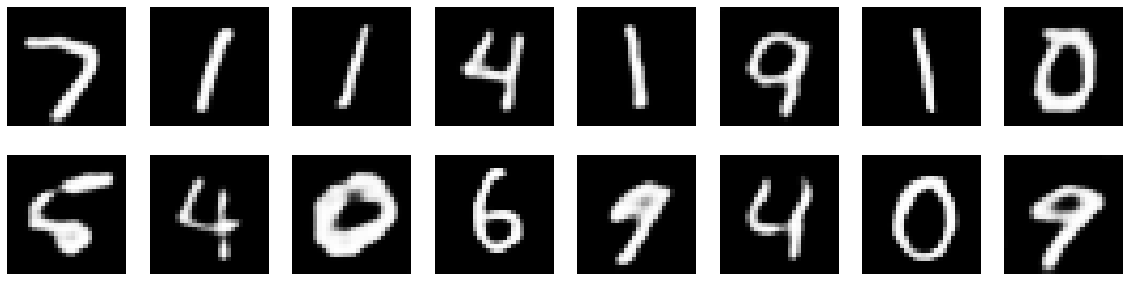

In [13]:
sample_batch = next(iter(val_dl))
visualize_images(model(sample_batch[0]).detach(), 2, 8)

In [14]:
transform_256 = transforms.Compose([
    transforms.Resize(size=(256,256)),
    NoiseTransform(p=0.75),
    transforms.ToTensor()
])

label_transform_256 = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])

In [15]:
train_dataset_256 = MNISTDataset(train=True, transform=transform_256, label_transform=label_transform_256)
val_dataset_256 = MNISTDataset(train=False, transform=transform_256, label_transform=label_transform_256)

train_dl_256 = DataLoader(train_dataset_256, batch_size=32, shuffle=True, num_workers=4)
val_dl_256 = DataLoader(val_dataset_256, batch_size=32, shuffle=False, num_workers=4)

In [16]:
# trainer = pl.Trainer(
#     max_epochs=5,
#     gpus=1,
#     callbacks=[
#         #MyEarlyStopping, 
#         MyModelCheckpoint
#     ],
#     log_every_n_steps=5
# )
# trainer.fit(model, train_dl_256, val_dl_256)

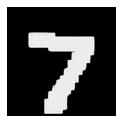

In [75]:
sample_batch = next(iter(val_dl_256))
visualize_images(model(sample_batch[0]).detach(), 2, 8)

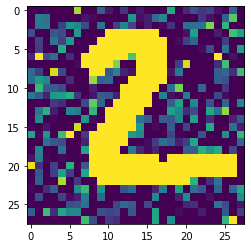

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [73]:
from skimage.io import imsave
sample_batch = next(iter(val_dl))
plt.imshow(sample_batch[0][1][0])
plt.show()

imsave('sample.png', sample_batch[0][1][0])

In [66]:
inp = np.array([[1, 3, 2, 1], [1, 3, 3, 1], [2, 1, 1, 3], [3, 2, 3, 3]])[None,None]
t_inp = torch.from_numpy(inp)
weight= np.array([[1, 2, 3], [0, 1, 0], [2, 1, 2]])[None,None]
t_weight = torch.from_numpy(weight)
t = nn.functional.conv_transpose2d(t_inp, weight=t_weight)

In [67]:
t


tensor([[[[ 1,  5, 11, 14,  8,  3],
          [ 1,  6, 15, 18, 12,  3],
          [ 4, 13, 21, 21, 15, 11],
          [ 5, 17, 28, 27, 25, 11],
          [ 4,  7,  9, 12,  8,  6],
          [ 6,  7, 14, 13,  9,  6]]]])

In [20]:
example = torch.rand(1, 1, 28, 28)
traced_script_autoencoder = torch.jit.trace(model.autoencoder, example)

In [21]:
for name, param in model.autoencoder.named_parameters():
    print(name, param)

enc_conv1.weight Parameter containing:
tensor([[[[ 8.5480e-03, -3.7737e-02,  6.9876e-02],
          [-4.7301e-02,  3.2224e-01,  3.4401e-01],
          [ 5.0616e-02,  3.5948e-01,  3.4451e-01]]],


        [[[-1.0212e-01,  2.7041e-01,  2.7438e-01],
          [-1.5510e-01,  1.9824e-01,  2.1076e-01],
          [-1.0552e-01, -7.3153e-02, -5.6413e-02]]],


        [[[-2.0882e-01, -1.1504e-01,  4.7745e-03],
          [-1.2151e-01,  1.7603e-01,  1.9287e-01],
          [-1.0148e-02,  1.7603e-01,  1.9271e-01]]],


        [[[ 1.4970e-02,  5.8539e-02, -1.4470e-01],
          [ 3.2062e-01,  3.1777e-01,  6.0717e-02],
          [ 2.9593e-01,  2.9593e-01,  8.0225e-04]]],


        [[[ 3.6592e-02,  2.1286e-01,  1.6297e-01],
          [ 3.6592e-02,  2.1021e-01,  1.8293e-01],
          [-1.3984e-01,  7.0802e-02,  6.8785e-02]]],


        [[[ 9.3132e-02,  6.1460e-02, -1.5210e-01],
          [ 1.4036e-02, -1.7836e-02,  3.7784e-03],
          [-1.0716e-01, -4.2434e-02,  1.4876e-01]]],


        [[[ 2.7600e

In [77]:
for name, param in traced_script_autoencoder.named_parameters():
    print(name, param.detach().numpy().shape)

enc_conv1.weight (32, 1, 3, 3)
enc_conv1.bias (32,)
enc_conv2.weight (32, 32, 3, 3)
enc_conv2.bias (32,)
dec_tconv1.weight (32, 32, 3, 3)
dec_tconv1.bias (32,)
dec_tconv2.weight (32, 32, 3, 3)
dec_tconv2.bias (32,)
dec_conv1.weight (1, 32, 3, 3)
dec_conv1.bias (1,)


In [76]:
traced_script_autoencoder.state_dict()['enc_conv1.bias'].numpy().reshape(-1).tolist()

[-0.08408499509096146,
 -0.1910579651594162,
 -0.10617329925298691,
 -0.20589253306388855,
 -0.08176480233669281,
 -0.0016379799926653504,
 -5.919814157095971e-06,
 0.42668864130973816,
 0.4481559097766876,
 0.2619360685348511,
 0.29821500182151794,
 1.719253085880118e-41,
 0.2398124784231186,
 0.2620781660079956,
 0.2433968186378479,
 -0.1736266016960144,
 -0.07346972078084946,
 -0.14587746560573578,
 -0.0525880828499794,
 0.4880215525627136,
 0.08654680103063583,
 -0.21916520595550537,
 4.030134383398174e-41,
 -0.21020878851413727,
 1.3124561416866237e-41,
 0.0589916966855526,
 0.18303436040878296,
 -0.12715663015842438,
 -0.07166920602321625,
 -0.13088831305503845,
 -0.015286389738321304,
 -0.05422703176736832]

In [25]:
traced_script_autoencoder.save("traced_autoencoder.pt")

In [26]:
torch.save(model.autoencoder.state_dict(), "state_dict.pt")

In [28]:
weights = traced_script_autoencoder.state_dict()['enc_conv1.weight'].numpy()

In [29]:
weights[0]

array([[[ 0.00854804, -0.03773678,  0.06987573],
        [-0.04730097,  0.3222371 ,  0.34401384],
        [ 0.05061597,  0.35948023,  0.3445117 ]]], dtype=float32)

In [30]:
weights[1]

array([[[-0.10211854,  0.27041152,  0.27438268],
        [-0.15509762,  0.19823892,  0.2107594 ],
        [-0.10551684, -0.07315256, -0.05641284]]], dtype=float32)

In [59]:
from array import array


def save_model_weights(model, output_path):
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    for param_name, weight in model.named_parameters():
        param_name = param_name.replace('.', '_') + '.bin'
        param_path = os.path.join(output_path, param_name)
        output_file = open(param_path, 'wb')
        float_array = array('f', weight.detach().cpu().numpy().reshape(-1))
        float_array.tofile(output_file)
        output_file.close()
    #output_file = open(filename, 'wb')
    #float_array = array('f', table_list) # f,d
    #float_array.tofile(output_file)
    #output_file.close()

In [60]:
save_model_weights(model.autoencoder, 'autoencoder_weights')

In [53]:
'enc.conv1.weight'.replace('.', '_')

'enc_conv1_weight'

In [57]:
array('f',weights[1].reshape(-1))

array('f', [-0.10211854428052902, 0.27041152119636536, 0.27438268065452576, -0.1550976186990738, 0.19823892414569855, 0.21075940132141113, -0.10551684349775314, -0.0731525644659996, -0.056412842124700546])

In [58]:
weights[1].reshape(-1)

array([-0.10211854,  0.27041152,  0.27438268, -0.15509762,  0.19823892,
        0.2107594 , -0.10551684, -0.07315256, -0.05641284], dtype=float32)

In [12]:
m = AutoEncoder()
m.load_state_dict(torch.load('state_dict.pt'))

<All keys matched successfully>

In [13]:
weights = m.state_dict()['enc_conv1.weight'].numpy()

In [15]:
weights[0]

array([[[ 0.00854804, -0.03773678,  0.06987573],
        [-0.04730097,  0.3222371 ,  0.34401384],
        [ 0.05061597,  0.35948023,  0.3445117 ]]], dtype=float32)

In [25]:
from array import array


def save_model_weights_new(model, output_path):
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    for param_name, weight in model.named_parameters():
        param_name = param_name.replace('.', '_') + '.bin'
        param_path = os.path.join(output_path, param_name)
        output_file = open(param_path, 'wb')
        if 'tconv' in param_name and 'bias' not in param_name:
            float_array = array('f', weight.detach().cpu().numpy().transpose((1,0,2,3)).reshape(-1))
        else:
            float_array = array('f', weight.detach().cpu().numpy().reshape(-1))
        float_array.tofile(output_file)
        output_file.close()
    #output_file = open(filename, 'wb')
    #float_array = array('f', table_list) # f,d
    #float_array.tofile(output_file)
    #output_file.close()

In [26]:
save_model_weights_new(m, 'autoencoder_weights_simple')

In [31]:
weight = np.array([1,2,0,-1,1,3,2,1,0,2,1,2,0,1,2,0,0,1,1,1,0,2,1,2,0,1,0,1,1,2,0,3,0,1,2,3,-1,2,1,0,1,2,0,1,0,1,1,0,2,1,0,2,2,2], dtype=np.float32).reshape(2,3,3,3)

In [33]:
bias = np.array([1,2], dtype=np.float32)

In [34]:
inp = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], dtype=np.float32).reshape(3,3,3)

In [36]:
t_inp = torch.from_numpy(inp[None])
t_weight = torch.from_numpy(weight)
t_bias = torch.from_numpy(bias)

F.conv2d(t_inp, t_weight, t_bias, padding=1)

tensor([[[[139., 197., 115.],
          [231., 344., 222.],
          [230., 341., 206.]],

         [[182., 285., 210.],
          [288., 423., 314.],
          [174., 251., 200.]]]])

In [31]:
from skimage.io import imread
m = AutoEncoder()
m.load_state_dict(torch.load('state_dict.pt'))
m.eval()
img = imread('sample.png')

In [32]:
img = img.astype(np.float32) / 255

In [33]:
m(torch.from_numpy(img[None,None]))

tensor([[[0.4288, 0.5282, 0.4648,  ..., 0.5300, 0.4200, 0.3386],
         [0.5420, 0.6269, 0.5712,  ..., 0.6244, 0.5300, 0.3994],
         [0.4786, 0.5712, 0.4763,  ..., 0.5643, 0.4597, 0.3691],
         ...,
         [0.6322, 0.7283, 0.6437,  ..., 0.6460, 0.5366, 0.3909],
         [0.4694, 0.5846, 0.5143,  ..., 0.4913, 0.4276, 0.3398],
         [0.3782, 0.4546, 0.4240,  ..., 0.3792, 0.3548, 0.2673]],

        [[0.4065, 0.5226, 0.4409,  ..., 0.5203, 0.3992, 0.3256],
         [0.4890, 0.5366, 0.5054,  ..., 0.5414, 0.4734, 0.3568],
         [0.4545, 0.5710, 0.4521,  ..., 0.5614, 0.4373, 0.3574],
         ...,
         [0.5823, 0.6338, 0.5774,  ..., 0.5686, 0.4850, 0.3505],
         [0.4470, 0.5790, 0.4882,  ..., 0.4863, 0.4069, 0.3270],
         [0.3682, 0.4345, 0.4070,  ..., 0.3599, 0.3421, 0.2485]],

        [[0.1958, 0.2512, 0.2062,  ..., 0.2475, 0.1879, 0.1443],
         [0.1620, 0.1792, 0.1598,  ..., 0.1781, 0.1603, 0.1274],
         [0.2157, 0.2691, 0.2090,  ..., 0.2642, 0.2035, 0.

tensor([[[[9.2384e-03, 4.1173e-04, 2.9102e-04, 3.8021e-04, 2.9155e-04,
           2.1965e-04, 1.3190e-04, 1.6817e-04, 1.5763e-04, 2.0274e-04,
           2.4153e-04, 5.8603e-04, 5.8879e-04, 4.2858e-04, 2.1065e-04,
           2.2637e-04, 1.6357e-04, 1.3387e-04, 8.5075e-05, 1.2734e-04,
           1.4549e-04, 1.9395e-04, 1.8043e-04, 2.8475e-04, 2.7837e-04,
           3.8732e-04, 6.9990e-04, 6.9529e-03],
          [3.0846e-04, 2.6064e-06, 2.1009e-06, 3.2567e-06, 2.1497e-06,
           1.1603e-06, 6.8255e-07, 1.2897e-06, 1.9185e-06, 4.5627e-06,
           1.2203e-05, 6.1365e-05, 7.0325e-05, 4.1929e-05, 1.8928e-05,
           1.8832e-05, 1.0872e-05, 5.0635e-06, 1.8145e-06, 1.4457e-06,
           1.1390e-06, 1.1118e-06, 1.0476e-06, 1.7533e-06, 1.7470e-06,
           2.6042e-06, 7.9305e-06, 3.9011e-04],
          [1.9835e-04, 1.6673e-06, 1.6797e-06, 3.0832e-06, 1.7662e-06,
           1.1079e-06, 1.0043e-06, 4.0353e-06, 1.5319e-05, 1.2204e-04,
           1.0085e-03, 8.6913e-03, 1.4462e-02, 1.144